In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np

table4 = Table.read('table4.txt', format='ascii', names='Star, Mbol, T, log g, [Fe/H], [Ti/H], [Ti/Fe]'.split(', '))

In [6]:
deltaFeH = 0.04 
deltaTiH = 0.05
deltaTiFe = 0.07

Text(0, 0.5, '[Ti/Fe]')

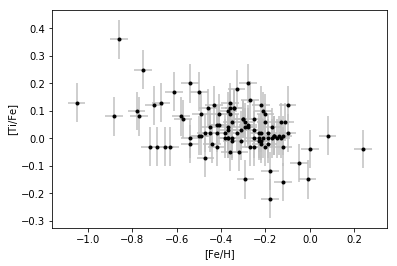

In [7]:
plt.errorbar(table4['[Fe/H]'], table4['[Ti/Fe]'], 
             xerr=deltaFeH, yerr=deltaTiFe, fmt='.', 
             ecolor='silver', color='k')
plt.xlabel('[Fe/H]')
plt.ylabel('[Ti/Fe]')

In [8]:

def v_vector(theta):
    """
    Hogg+ 2010, Eqn 29.
    """
    return [[-np.sin(theta)], [np.cos(theta)]]


def lnprior(p, max_theta=2*np.pi, min_theta=0):
    theta, b = p
    if not ((min_theta < theta < max_theta) and (-1 < b < 1)):
        return -np.inf
    else:
        return 0


def ln_likelihood(p, x, y, x_err, y_err):
    """
    Hogg+ 2010, Eqn 30., with an additional parameter that scales up the
    uncertainty in the x dimension, ``x_err``, by a constant factor.

    The likelihood has been written assuming x and y uncertainties are
    uncorrelated.
    """
    theta, b = p

    v = v_vector(theta)

    lnp = lnprior(p)
    if not np.isfinite(lnp):
        return lnp

    delta = v[0][0] * x + v[1][0] * y - b * np.cos(theta)

    sigma_sq = v[0][0]**2 * x_err**2 + v[1][0]**2 * y_err**2
    ln_like = np.sum(-0.5 * (delta**2 / sigma_sq + np.log(sigma_sq) +
                     np.log(2*np.pi)))
    return ln_like

In [9]:
from multiprocessing import Pool
import emcee

init_guess = [np.radians(120), 0.3]
nwalkers = 10
n_steps_burnin = 2000
n_steps_postburnin = 5000

ndim = len(init_guess)
p0 = []

while len(p0) < nwalkers:
    trial = [init_guess[0] + 0.05 * np.random.randn(),
             init_guess[1] + 0.01 * np.random.randn()]
    if np.isfinite(lnprior(trial)):
        p0.append(trial)

# args = (s_apo.value, s_mwo.value, s_apo.err, s_mwo.err)
args = (table4['[Fe/H]'], table4['[Ti/Fe]'], 
        deltaFeH, deltaTiFe)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args=args,
                                    pool=pool)

    # Burn in for this many steps:
    p1 = sampler.run_mcmc(p0, n_steps_burnin)
    sampler.reset()

    p2 = sampler.run_mcmc(p1, n_steps_burnin)
    sampler.reset()

    # Now run for this many more steps:
    sampler.run_mcmc(p2, n_steps_postburnin)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

In [10]:
from corner import corner

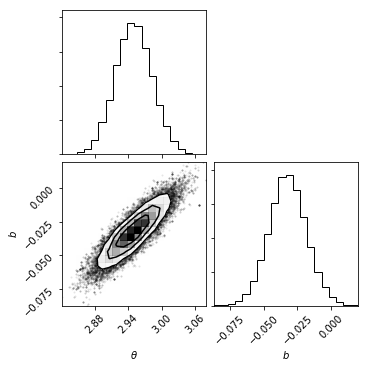

In [31]:
corner(samples, labels='$\\theta$ $b$'.split());
plt.savefig('corner.pdf', bbox_inches='tight')

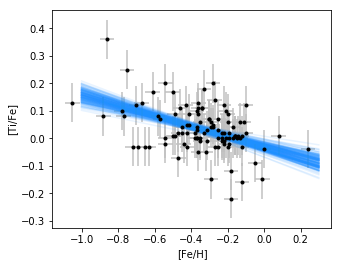

In [30]:
plt.figure(figsize=(5, 4))
plt.errorbar(table4['[Fe/H]'], table4['[Ti/Fe]'], 
             xerr=deltaFeH, yerr=deltaTiFe, fmt='.', 
             ecolor='silver', color='k')
plt.xlabel('[Fe/H]')
plt.ylabel('[Ti/Fe]')

n_lines = 200

x = np.linspace(-1, 0.3, 100)

for n in range(n_lines):
    randint = np.random.randint(0, len(samples))
    
    theta, b = samples[randint, :]
    
    y = b - x * np.sin(theta)
    
    plt.plot(x, y, alpha=0.1, color='DodgerBlue')
plt.savefig('figure1.pdf', bbox_inches='tight')

In [35]:
np.count_nonzero(samples[:, 0] < np.pi) / len(samples[:, 0])

1.0